<a href="https://colab.research.google.com/github/rezzie-rich/colab-notebooks/blob/main/coco-se-unsloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🛠️✨ unsloth-repair-bay ✨🛠️**

# 🚀 Experience the Future of AI 🚀

with our cutting-edge model training pipeline.

Using Unsloth and Hugging Face, our system fine-tunes powerful language models to handle vast contexts and deliver exceptional performance. Whether you're crafting complex narratives 📚 or developing intelligent chatbots 🤖, our pipeline ensures optimal results with streamlined, efficient processes.

🌟 Step into the next era of AI with unparalleled ease and precision. 🌟


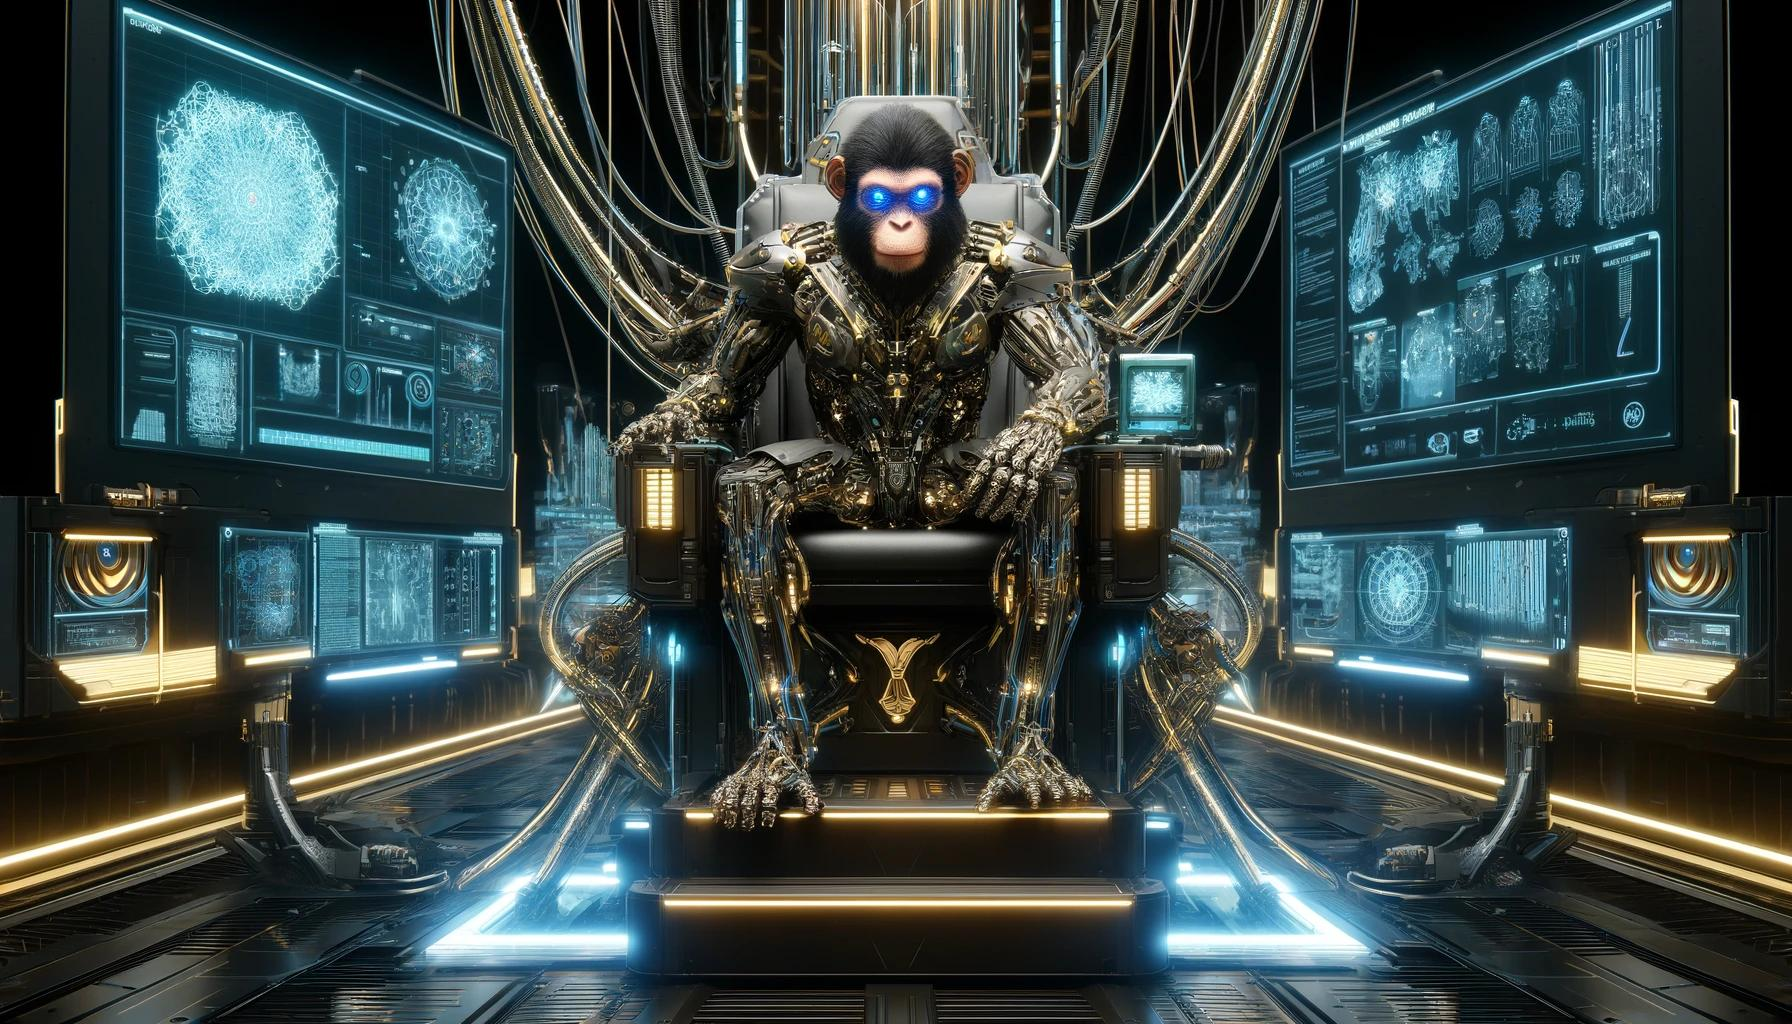

# Colab Setup

These commands install Unsloth and other necessary libraries. Unsloth is installed from its GitHub repository, and specific versions of libraries like trl, peft, accelerate, bitsandbytes, and safetensors are installed to ensure compatibility and functionality.

In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes safetensors

# Importing Libraries

The essential libraries for model training and fine-tuning are imported. These include Unsloth's FastLanguageModel, datasets for loading data, SFTTrainer from the TRL library for training, and necessary components from the Transformers library.

In [ ]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth.chat_templates import get_chat_template

# Define local storage path

When referring to "local storage" in the context of Google Colab, it means the storage available on the Colab cloud virtual machine. This storage is not persistent and will be reset when the Colab instance is restarted or disconnected.



In [ ]:
local_storage_path = "/content/unsloth-models"

# Model Configuration

Configuration settings for the model. max_seq_length sets the maximum sequence length for inputs. dtype is set to auto-detect the appropriate data type, and load_in_4bit enables QLoRA for efficient 4-bit quantization.

In [ ]:
max_seq_length = 4096
dtype = None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # Enable QLoRA

# Function to validate dataset fields

This function is crucial for data validation to ensure that the necessary data structure is in place before any training or processing begins. It helps prevent runtime errors that would occur if expected data fields are missing.

In [ ]:
def validate_dataset(dataset, required_field):
    if required_field not in dataset.column_names:
        raise ValueError(f"Required field '{required_field}' not found in the dataset. Available fields: {dataset.column_names}")

# Function to log error messages

This function is used throughout the script in try-except blocks to log specific errors encountered during various stages of execution. It helps in identifying and diagnosing issues efficiently by providing context about where and what kind of error occurred.

In [ ]:
def log_error(stage, error):
    print(f"Error during {stage}: {error}")

# Initialize model and tokenizer

The model and tokenizer are initialized from a pre-trained model provided by Unsloth. The settings for maximum sequence length, data type, and 4-bit loading are applied. If an error occurs during initialization, it is logged.

In [ ]:
try:
    model, tokenizer = FastLanguageModel.from_pretrained(
        "unsloth/Phi-3-medium-4k-instruct",
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit
    )
except Exception as e:
    log_error("model initialization", e)
    raise

# Add LoRA adapters for the first dataset

LoRA adapters are added to the model. These adapters help in reducing the number of trainable parameters, making the training process more efficient. The parameters such as r, lora_alpha, and lora_dropout configure the LoRA setup.

In [ ]:
model = FastLanguageModel.get_peft_model(
          model,
          r=16,  # Rank of the adaptation
          target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
          lora_alpha=16,
          lora_dropout=0.4,  # No dropout for LoRA
          bias="none",  # No bias adaptation
          use_gradient_checkpointing="unsloth",  # Use Unsloth's gradient checkpointing
          random_state=3399,
          use_rslora=True,   # Use rank stabilized LoRA
          loftq_config=None  # No additional quantization configuration
)

# Data preparation function

A function to format the prompts from the dataset. It applies a chat template to each conversation in the dataset to standardize the input format for training.

In [ ]:
def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False) for convo in convos]
    return {"text": texts}

# Load and prepare the first dataset

The first dataset is loaded from Hugging Face. The dataset is validated to ensure it contains the required fields. The tokenizer is configured with a chat template, and the dataset is formatted accordingly.

In [ ]:
try:
    dataset1 = load_dataset("allenai/dolma")
    validate_dataset(dataset1['train'], "text")
    tokenizer = get_chat_template(
        tokenizer,
        chat_template="phi-3",
        mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"}
    )
    dataset1 = dataset1.map(formatting_prompts_func, batched=True)
except Exception as e:
    log_error("loading or validating the first dataset", e)
    raise

# Determine the appropriate dtype for mixed precision training

This logic checks if the hardware supports Bfloat16. If not, it defaults to using Float16. This helps in optimizing the training process based on the hardware capabilities.

In [ ]:
use_fp16 = not is_bfloat16_supported()
use_bf16 = is_bfloat16_supported()

# Training with the first dataset

The training arguments are set up, including batch size, learning rate, and the use of mixed precision. SFTTrainer is used to train the model with the first dataset. If any error occurs, it is logged.

In [ ]:
try:
    training_args1 = TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=16,
        warmup_steps=800,
        max_steps=300000,
        learning_rate=1e-4,
        fp16=use_fp16,
        bf16=use_bf16,
        logging_steps=7,
        optim="adamw_8bit",
        weight_decay=0.07,
        lr_scheduler_type="cosine",
        seed=3399,
        output_dir=f"{local_storage_path}/outputs_phase1",
    )

    trainer1 = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=dataset1['train'],
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        dataset_num_proc=4,
        packing=True,
        args=training_args1,
    )

    trainer1.train()
except Exception as e:
    log_error("training with the first dataset", e)
    raise

# Save the intermediate model

After training with the first dataset, the model is saved.

In [ ]:
try:
    model.save_pretrained(f"{local_storage_path}/intermediate_model")
except Exception as e:
    log_error("saving the intermediate model", e)
    raise

# Load the intermediate model

Model is then reloaded for further training with the second dataset. This helps in managing the training process and checkpoints effectively.

In [ ]:
try:
    model = FastLanguageModel.from_pretrained(f"{local_storage_path}/intermediate_model")
except Exception as e:
    log_error("loading the intermediate model", e)
    raise

# Add LoRA adapters for the second dataset

LoRA adapters are added again with different settings for the second dataset. This allows for flexibility in fine-tuning the model with various data characteristics.

In [ ]:
model = FastLanguageModel.get_peft_model(
          model,
          r=32,  # Different rank for the second dataset
          target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
          lora_alpha=32,
          lora_dropout=0.2,  # Different dropout for LoRA
          bias="none",  # No bias adaptation
          use_gradient_checkpointing="unsloth",  # Use Unsloth's gradient checkpointing
          random_state=3399,
          use_rslora=True,   # Use rank stabilized LoRA
          loftq_config=None  # No additional quantization configuration
)

# Load and prepare the second dataset

The second dataset is loaded and validated. The tokenizer is configured with a chat template, and the dataset is formatted for training.

In [ ]:
try:
    dataset2 = load_dataset("xingyaoww/code-act")
    validate_dataset(dataset2['train'], "code")
    tokenizer = get_chat_template(
        tokenizer,
        chat_template="phi-3",
        mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"}
    )
    dataset2 = dataset2.map(formatting_prompts_func, batched=True)
except Exception as e:
    log_error("loading or validating the second dataset", e)
    raise

# Training with the second dataset

Similar to the first dataset, the training arguments are set up, and SFTTrainer is used to train the model with the second dataset.

In [ ]:
try:
    training_args2 = TrainingArguments(
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        warmup_steps=50,
        max_steps=1000,
        learning_rate=1e-4,
        fp16=use_fp16,
        bf16=use_bf16,
        logging_steps=7,
        optim="adamw_8bit",
        weight_decay=0.07,
        lr_scheduler_type="cosine",
        seed=3399,
        output_dir=f"{local_storage_path}/outputs_phase2",
    )

    trainer2 = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=dataset2['train'],
        dataset_text_field="code",
        max_seq_length=max_seq_length,
        dataset_num_proc=4,
        packing=True,
        args=training_args2,
    )

    trainer2.train()
except Exception as e:
    log_error("training with the second dataset", e)
    raise

# Inference

The inference is set up to generate text responses using the trained model. The tokenizer is configured with a chat template, and input messages are prepared for generation. TextStreamer is used to generate outputs efficiently.

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template="phi-3",
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"}
)

FastLanguageModel.for_inference(model)  # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Continue the Fibonacci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,  # Must add for generation
    return_tensors="pt",
).to("cuda")

# Generate output using TextStreamer
streamer = TextStreamer(tokenizer)
outputs = model.generate(input_ids=inputs, max_new_tokens=64, use_cache=True, streamer=streamer)

response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("Generated response:", response[0])

# Save the final model in FP16 safetensors format

The final model is saved in FP16 safetensors format for efficient storage and deployment. The model is also pushed to the Hugging Face Hub, making it accessible for future use.

In [ ]:
final_model_name01 = "coco-se-phi3-medium-pro"
try:
    model = model.to(dtype=torch.float16)

    model.push_to_hub(
        repo_id=f"{final_model_name01}",
        use_auth_token="",  # Replace with your Hugging Face token
        safe_serialization=True
    )
except Exception as e:
    log_error("pushing FP16 safetensors model", e)
    raise

# Quantize and save Q8 model in safetensors format

The final model is then saved in Q8 safetensors format for more efficient storage and deployment. The model is quantized to 8 bits (Q8) to reduce its size and computational requirements while maintaining performance. The model is also pushed to the Hugging Face Hub, making it accessible for future use.

In [ ]:
final_model_name02 = "coco-se-phi3-medium"
try:
    quantized_model = model.quantize(
        bits=8,
        dtype=torch.float16,
        quantization_method="q8_0"
    )
    quantized_model.push_to_hub(
        repo_id=f"{final_model_name02}",
        use_auth_token="",  # Replace with your Hugging Face token
        safe_serialization=True
    )
except Exception as e:
    log_error("pushing Q8 safetensors model", e)
    raise

# Quantize and save Q8 model in GGUF format

Finally the model is saved in Q8 and GGUF for CPU only usage.

In [ ]:
final_model_name03 = "coco-se-phi3-medium-GGUF"
try:
    model.push_to_hub_gguf(
        f"{final_model_name03}",
        quantization_method="q8_0",
        use_auth_token=""  # Replace with your Hugging Face token
    )
except Exception as e:
    log_error("pushing GGUF model", e)
    raise